In [1]:
from Utils import PlotUtlis, create_folder, mm2inch, set_mpl_defaults, convert_to_env_list_detail

import yaml
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
import math
import feather
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib as mpl
from scipy.stats import skewnorm
import matplotlib.ticker as mtick

set_mpl_defaults()

In [2]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'

In [3]:
PU = PlotUtlis(run_id = run_id, exp_id = exp_id)

In [4]:
create_folder(PU.plot_path_nichespace_clustering)

# 繪製不同模型的biotop

In [5]:
nichespace_deepsdm_all, nichespace_deepsdm_all_nonflatten = PU.get_deepsdm_nichespace(suffix = 'max')

### clustering

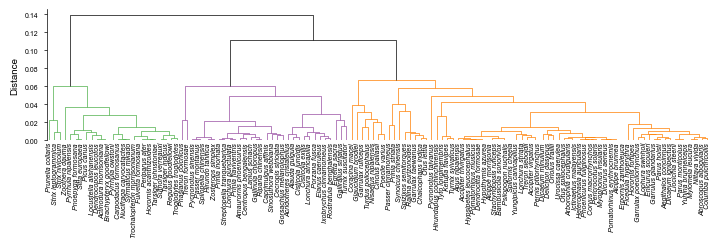

In [6]:
# 假設找到最佳分群數 k_optimal
k_optimal = 3

# 進行階層式聚類，選擇 'average' linkage
linked = linkage(nichespace_deepsdm_all, method='average', metric='cosine')

# 根據最佳分群數來提取分群結果
cluster_labels = fcluster(linked, t=k_optimal, criterion='maxclust')

# 計算分群的距離閾值
max_d = linked[-(k_optimal-1), 2]  # 提取合併最佳分群數時的距離

# 繪製樹狀圖 (Dendrogram)
fig, ax = plt.subplots(figsize=mm2inch(180, 60), constrained_layout = True)
set_link_color_palette(PU.color_list)
d_data = dendrogram(
    linked,
    orientation='top',
    distance_sort='ascending',
    show_leaf_counts=False,
    color_threshold=max_d,   # 使用該閾值來確保生成正確數量的顏色
    labels=[sp.replace('_', ' ') for sp in PU.species_list_predict], 
    above_threshold_color = 'black', 
    ax = ax
)

# 調整X軸標籤（物種名稱）的字體大小
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 5, fontstyle='italic', rotation=90, ha='center', va = 'top')
ax.set_ylabel('Distance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# 針對該 Axes 上所有的 LineCollection，統一設置線條寬度
for line_collection in ax.collections:
    line_collection.set_linewidth(0.5)  # 想要多粗就填多少
    
ax.tick_params(axis='x', which='major', pad=-1)

plot_output = os.path.join(PU.plot_path_nichespace_clustering, 'nichespace_clustering_dendrogram.pdf')
# plt.savefig(plot_output, dpi = 500, transparent = True)
plt.show()

In [7]:
all_cluster_avg_niches = PU.get_all_cluster_average_nichespace(cluster_labels, nichespace_deepsdm_all_nonflatten)
img_sign = np.sign(all_cluster_avg_niches[0][1])

Cluster 1 - Average niche calculated from 25 species.
Cluster 2 - Average niche calculated from 32 species.
Cluster 3 - Average niche calculated from 68 species.


In [10]:
with open(PU.cluster_labels_path, 'w') as f:
    yaml.dump(cluster_labels.tolist(), f)
    
all_cluster_avg_niches_converted = {int(i):j.tolist() for i, j in all_cluster_avg_niches}
with open(PU.cluster_avg_nichespace_path, 'w') as f:
    yaml.dump(all_cluster_avg_niches_converted, f)

### average niche space of each cluster

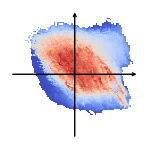

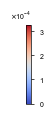

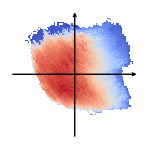

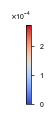

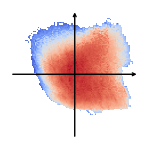

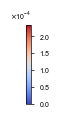

In [57]:
from matplotlib.ticker import ScalarFormatter
for (i_img, img) in all_cluster_avg_niches:
    fig, ax = plt.subplots(figsize = mm2inch(35, 35), constrained_layout = True)
    img_nan = np.where(img <= 0, np.nan, img)
    ax.imshow(img_nan, vmin = 0, cmap = 'coolwarm', extent = PU.nichespace_extent)
    ax.axis('off')
    
    # X axis arrow
    ax.annotate(
        '',
        xy=(6, 0),
        xytext=(-6, 0),
        arrowprops=dict(facecolor='black', arrowstyle='->')
    )

    # Y axis arrow
    ax.annotate(
        '',
        xy=(0, 6),
        xytext=(0, -6),
        arrowprops=dict(facecolor='black', arrowstyle='->')
    )
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    
    plot_output = os.path.join(PU.plot_path_nichespace_clustering, f'nichespace_avg_cluster{i_img}.pdf')
    plt.savefig(plot_output, transparent = True, dpi = 500)
    plt.show()
    
    # Plot separate colorbar
    fig_cb, ax_cb = plt.subplots(figsize = mm2inch(10, 25), gridspec_kw = {'left': 0.38, 'right': 0.5, 'bottom': 0.05, 'top': 0.85})
    norm = plt.Normalize(vmin = 0, vmax = np.nanmax(img_nan))
    cb = fig_cb.colorbar(plt.cm.ScalarMappable(norm = norm, cmap='coolwarm'), cax = ax_cb, orientation = 'vertical')
    
    formatter = mtick.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax_cb.yaxis.set_major_formatter(formatter)
    
    cb_output = os.path.join(PU.plot_path_nichespace_clustering, f'nichespace_avg_cluster{i_img}_colorbar.pdf')
    plt.savefig(cb_output, transparent=True, dpi=500)
    plt.show()

In [10]:
df_center = PU.calculate_deepsdm_nichespace_center(nichespace_deepsdm_all_nonflatten, cluster_labels)
df_center.to_csv(PU.df_nichespace_center_coordinate_path)
df_center

,PC01,PC02,cluster
Abroscopus_albogularis,0.927447,0.430583,3
Accipiter_trivirgatus,0.782647,0.375229,3
Accipiter_virgatus,0.770502,0.298941,3
Acridotheres_cristatellus,0.016405,0.317745,2
Actinodura_morrisoniana,0.614850,0.932766,1
...,...,...,...
Urocissa_caerulea,0.944370,0.375724,3
Yuhina_brunneiceps,0.941936,0.696037,3
Yungipicus_canicapillus,0.748895,0.347465,3
Zoothera_dauma,0.631714,0.793014,1


In [11]:
df_cor_center_maxvariance, center_maxvarinace_slope = PU.calculate_correlation_center_maxvariance(df_center)
df_cor_center_maxvariance

,Environmental Factor,Correlation with Max Variance Direction
0,clt,0.777003
1,hurs,0.771847
7,landcover_PC00,-0.663204
3,rsds,-0.488772
2,pr,0.451934
5,tas,-0.430576
6,EVI,0.262808
4,sfcWind,-0.216854
11,landcover_PC04,-0.118655
8,landcover_PC01,0.101326


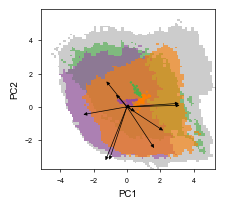

In [12]:
fig, ax = plt.subplots(figsize=mm2inch(55, 50), constrained_layout = True)
ax.imshow(np.where(img_sign == 1, img_sign, np.nan), alpha = 0.4, extent = PU.nichespace_extent, cmap = ListedColormap('grey'))
cluster1_avg_niche = np.where(all_cluster_avg_niches[0][1] > 0, all_cluster_avg_niches[0][1], np.nan)
cluster1_threshold = np.nanpercentile(cluster1_avg_niche, 50)
ax.imshow(np.where(cluster1_avg_niche >= cluster1_threshold, 1, np.nan), extent = PU.nichespace_extent, cmap = ListedColormap('#4daf4a'), alpha = 0.6)

cluster2_avg_niche = np.where(all_cluster_avg_niches[1][1] > 0, all_cluster_avg_niches[1][1], np.nan)
cluster2_threshold = np.nanpercentile(cluster2_avg_niche, 50)
ax.imshow(np.where(cluster2_avg_niche >= cluster2_threshold, 1, np.nan), extent = PU.nichespace_extent, cmap = ListedColormap('#984ea3'), alpha = 0.6)

cluster3_avg_niche = np.where(all_cluster_avg_niches[2][1] > 0, all_cluster_avg_niches[2][1], np.nan)
cluster3_threshold = np.nanpercentile(cluster3_avg_niche, 50)
ax.imshow(np.where(cluster3_avg_niche >= cluster3_threshold, 1, np.nan), extent = PU.nichespace_extent, cmap = ListedColormap('#ff7f00'), alpha = 0.6)


# 繪製從原點出發的箭頭，並在箭頭末端標記變數名稱
for env in PU.env_list:
    dx = PU.env_pca_loadings.loc[env][f'PC{PU.x_pca:02d}']*4
    dy = PU.env_pca_loadings.loc[env][f'PC{PU.y_pca:02d}']*4
    ax.annotate(
        '',                             # 沒有文字
        xy=(dx, dy),                    # 箭頭終點
        xytext=(0, 0),                  # 箭頭起點
        arrowprops=dict(
            arrowstyle='-|>',            # 箭頭樣式
            lw=0.5,                       # 線寬（數據單位，可配合 mutation_scale 調整）
            mutation_scale=5,            # 箭頭頭部尺寸的縮放因子，單位是 pt
            fc='black',              # 填充顏色設定為黑色
            shrinkA = 0, 
            shrinkB = 0
        )
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.scatter(x=df_center['PC01'],
           y=df_center['PC02'],
           c=cluster_labels,
           cmap=ListedColormap(PU.color_list), 
           s = 0.5)
plot_output = os.path.join(PU.plot_path_nichespace_clustering, 'cluster_mean_env.pdf')
# plt.savefig(plot_output, transparent = True, dpi = 500)
plt.show()


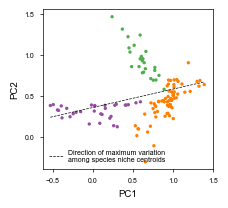

In [13]:
fig, ax = plt.subplots(figsize=mm2inch(55, 50), constrained_layout = True)
ax.scatter(x=df_center['PC01'],
           y=df_center['PC02'],
           c=cluster_labels,
           cmap=ListedColormap(PU.color_list), 
           s = 2)

# 計算原始數據的中心點，用於平移變異最大方向的直線
center_x = df_center["PC01"].mean()
center_y = df_center["PC02"].mean()
# 繪製平移後的最大變異方向直線 (y = slope * (x - center_x) + center_y)
x_vals_shifted = np.linspace(df_center["PC01"].min(), df_center["PC01"].max(), 100)
y_vals_shifted = center_maxvarinace_slope * (x_vals_shifted - center_x) + center_y

ax.plot(x_vals_shifted, y_vals_shifted, color="black", linestyle="--", linewidth=0.5, label="Direction of maximum variation \namong species niche centroids")

ax.legend(loc='lower left', frameon=False)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_yticks([0, 0.5, 1, 1.5])

plot_output = os.path.join(PU.plot_path_nichespace_clustering, 'niche_center_maxvariance.pdf')
# plt.savefig(plot_output, transparent = True, dpi = 500)
plt.show()

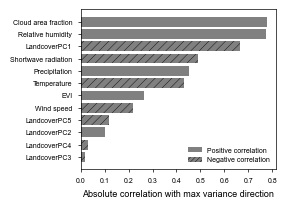

In [14]:
mpl.rcParams['hatch.linewidth'] = 0.3
fig, ax = plt.subplots(figsize=mm2inch(70, 50), constrained_layout=True)

# 取得 y 軸的標籤（依照 env_list_change 字典對應）
y_labels = convert_to_env_list_detail(df_cor_center_maxvariance["Environmental Factor"])

# 逐一繪製每個 bar
for i, (env, corr) in enumerate(zip(df_cor_center_maxvariance["Environmental Factor"],
                                      df_cor_center_maxvariance["Correlation with Max Variance Direction"])):
    # 取絕對值作為 bar 長度
    value = abs(corr)
    if corr < 0:
        # 負相關性的 bar 加上斜線 hatch
        ax.barh(y_labels[i], value, color="grey", hatch="////")
    else:
        # 正相關性的 bar 直接繪製
        ax.barh(y_labels[i], value, color="grey")

# 設定 x 軸標籤
ax.set_xlabel("Absolute correlation with max variance direction", fontsize=6.5)

# 讓最高相關性出現在頂部
ax.invert_yaxis()

# 移除背景線條
ax.grid(False)

# 產生 legend，說明正負相關性的 bar 樣式
legend_elements = [
    Patch(facecolor='grey', label='Positive correlation'),
    Patch(facecolor='grey', hatch='///////', label='Negative correlation')
]
ax.legend(handles=legend_elements)

plot_output = os.path.join(PU.plot_path_nichespace_clustering, 'correlation_env_maxvariance.pdf')
# plt.savefig(plot_output, transparent=True, dpi=500)
plt.show()


Cloud area fraction
0.12722433


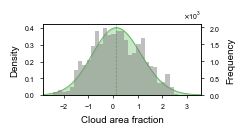

-0.38104334


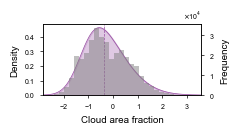

-0.13941677


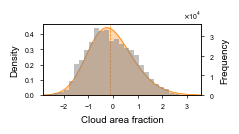

Relative humidity
-0.62417644


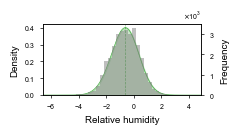

-0.49514565


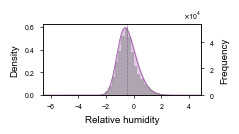

-0.22866534


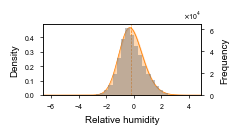

LandcoverPC1
-0.39305097


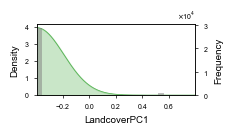

0.6619131


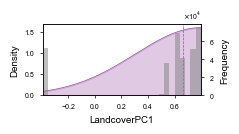

-0.39305097


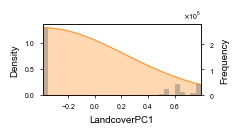

In [15]:
for env_plot in ['clt', 'hurs', 'landcover_PC00']:
    print(convert_to_env_list_detail([env_plot])[0])
    
    env_value_cluster_all = PU.get_cluster_env_values(cluster_labels, env_plot)

    env_min = PU.df_env_pca[sorted([key for key in PU.df_env_pca.keys() if key.startswith(env_plot)])].values.flatten().min()
    env_max = PU.df_env_pca[sorted([key for key in PU.df_env_pca.keys() if key.startswith(env_plot)])].values.flatten().max()

    for (i_cluster, env_value_cluster) in env_value_cluster_all:

        fig, ax_pdf = plt.subplots(figsize=mm2inch(60, 30),
                                   gridspec_kw={'left': 0.18, 'right': 0.85, 'bottom': 0.25, 'top': 0.85})

        ax_hist = ax_pdf.twinx()

        # Plot histogram on the right y-axis
        ax_hist.hist(env_value_cluster, bins=30, density=False, alpha=0.5, color='gray', label='Observed Data')
        ax_hist.set_ylabel('Frequency')

        formatter = mtick.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((0, 0))
        ax_hist.yaxis.set_major_formatter(formatter)


        # Skewed normal PDF on the left y-axis
        x_vals = np.linspace(env_min, env_max, 300)
        a, loc, scale = skewnorm.fit(env_value_cluster)
        skewed_pdf = skewnorm.pdf(x_vals, a, loc, scale)

        ax_pdf.plot(x_vals, skewed_pdf, color=PU.color_list[i_cluster-1], lw=0.5)
        ax_pdf.fill_between(x_vals, skewed_pdf, color=PU.color_list[i_cluster-1], alpha=0.3)
        ax_pdf.set_ylabel('Density')

        median_val = np.median(env_value_cluster)
        print(median_val)
        ax_pdf.axvline(median_val, linestyle='--', color=PU.color_list[i_cluster-1], linewidth=0.5)

        ax_pdf.set_xlabel(convert_to_env_list_detail([env_plot])[0])

        ax_pdf.set_xlim(env_min, env_max)
        ax_pdf.set_ylim(bottom=0)
        
        plot_output = os.path.join(PU.plot_path_nichespace_clustering, f'{env_plot}_{i_cluster}.pdf')
        plt.savefig(plot_output, dpi=500, transparent=True)
        plt.show()